#### 1. Statistical Analysis (Comparing if Mean-Chebyshev is equal to SLSQP(+))

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon, shapiro

# Set up paths
project_root = Path().resolve().parent
optimal_file = project_root / 'output' / 'optimal_parameters_by_algorithm.csv'
grouped_file = project_root / 'output' / 'grouped_device_results.csv'

print("="*80)
print("STATISTICAL ANALYSIS: Mean-Chebyshev vs SLSQP(+)")
print("Comparing algorithms for each ρ₀ using their optimal parameter choices")
print("="*80)

# Load the data
print("\n1. Loading data...")
optimal_data = pd.read_csv(optimal_file)
grouped_data = pd.read_csv(grouped_file)

print(f"Optimal parameters shape: {optimal_data.shape}")
print(f"Grouped device results shape: {grouped_data.shape}")
print(f"Algorithms in optimal data: {optimal_data['algorithm'].unique()}")
print(f"Algorithms in grouped data: {grouped_data['algorithm'].unique()}")

# Function to safely parse error list strings
def parse_error_list(error_str):
    """Convert string representation of list back to actual list of floats"""
    try:
        clean_str = error_str.strip('[]').replace(' ', '')
        if clean_str:
            return [float(x) for x in clean_str.split(',') if x.strip()]
        else:
            return []
    except (ValueError, TypeError, AttributeError):
        return []

# Parse error lists in grouped data
print("\n2. Parsing error lists...")
grouped_data['error_list'] = grouped_data['error_list_str'].apply(parse_error_list)

# Create a new dataframe for analysis
analysis_df = pd.DataFrame({
    'algorithm': optimal_data['algorithm'],
    'rho_0': optimal_data['rho_0'],
    'alpha': optimal_data['alpha'],
    'error_list_str': ""
})

# The error_list_str column will be filled with the corresponding grouped_data column (error_list_str)
# Each error_list_str row comes from the grouped_data where rho_0 and alpha match. Also, for the optimal_data['algorithm'] values,
# 'Mean-Chebyshev', 'Mean_Euclidean' and 'SLSQP(+)' correspond to grouped_data['algorithm'] == 'SLSQP(+)' in grouped_data, whereas 'NN' in optimal_data['algorithm'] correspond to grouped_data['algorithm'] == 'NN'
for index, row in analysis_df.iterrows():
    algorithm = row['algorithm']
    rho_0 = row['rho_0']
    alpha = row['alpha']

    # Find the corresponding error_list_str in grouped_data
    if algorithm in ['Mean-Chebyshev', 'Mean_Euclidean', 'SLSQP(+)']:
        error_row = grouped_data[
            (grouped_data['algorithm'] == 'SLSQP(+)') &
            (grouped_data['rho_0'] == rho_0) &
            (grouped_data['alpha'] == alpha)
        ]
    elif algorithm == 'NN':
        error_row = grouped_data[
            (grouped_data['algorithm'] == 'NN') &
            (grouped_data['rho_0'] == rho_0) &
            (grouped_data['alpha'] == alpha)
        ]
    else:
        error_row = pd.DataFrame()  # No match for other algorithms

    if not error_row.empty:
        analysis_df.at[index, 'error_list_str'] = error_row['error_list_str'].values[0]

# Filtering dataframe to only include Mean-Chebyshev and SLSQP(+)
analysis_df = analysis_df[analysis_df['algorithm'].isin(['Mean-Chebyshev', 'SLSQP(+)'])].copy().reset_index(drop=True)
print(f"Analysis DataFrame preview: \n{analysis_df.head()}")

STATISTICAL ANALYSIS: Mean-Chebyshev vs SLSQP(+)
Comparing algorithms for each ρ₀ using their optimal parameter choices

1. Loading data...
Optimal parameters shape: (68, 4)
Grouped device results shape: (782, 7)
Algorithms in optimal data: ['Mean-Chebyshev' 'Mean-Euclidean' 'NN' 'SLSQP(+)']
Algorithms in grouped data: ['NN' 'SLSQP(+)']

2. Parsing error lists...
Analysis DataFrame preview: 
        algorithm  rho_0  alpha  \
0  Mean-Chebyshev   40.0   5.50   
1  Mean-Chebyshev   42.5   5.25   
2  Mean-Chebyshev   45.0   5.25   
3  Mean-Chebyshev   47.5   5.00   
4  Mean-Chebyshev   50.0   4.75   

                                      error_list_str  
0  [1.66, 2.49, 6.38, 2.71, 1.94, 5.06, 2.0, 1.94...  
1  [1.13, 1.66, 6.38, 2.65, 1.94, 5.06, 2.0, 1.94...  
2  [1.71, 1.91, 6.38, 3.38, 3.08, 5.03, 2.0, 1.94...  
3  [1.67, 1.88, 6.38, 2.29, 3.08, 5.03, 4.58, 1.9...  
4  [1.58, 1.87, 6.57, 3.65, 3.08, 5.03, 4.4, 1.94...  
Analysis DataFrame preview: 
        algorithm  rho_0  alpha  \


In [4]:
# New dataframe with columns rho_0, error_list_chebyshev, error_list_slsqp
pair_analysis_df = pd.DataFrame({
    'rho_0': analysis_df['rho_0'].unique(),
    'error_list_chebyshev': analysis_df[analysis_df['algorithm'] == 'Mean-Chebyshev']['error_list_str'].reset_index(drop=True),
    'error_list_slsqp': analysis_df[analysis_df['algorithm'] == 'SLSQP(+)']['error_list_str'].reset_index(drop=True)
})

# Parse error lists in pair_analysis_df
pair_analysis_df['error_list_chebyshev'] = pair_analysis_df['error_list_chebyshev'].apply(parse_error_list)
pair_analysis_df['error_list_slsqp'] = pair_analysis_df['error_list_slsqp'].apply(parse_error_list)

print(f"Pair Analysis DataFrame preview: \n{pair_analysis_df.head()}")

Pair Analysis DataFrame preview: 
   rho_0                               error_list_chebyshev  \
0   40.0  [1.66, 2.49, 6.38, 2.71, 1.94, 5.06, 2.0, 1.94...   
1   42.5  [1.13, 1.66, 6.38, 2.65, 1.94, 5.06, 2.0, 1.94...   
2   45.0  [1.71, 1.91, 6.38, 3.38, 3.08, 5.03, 2.0, 1.94...   
3   47.5  [1.67, 1.88, 6.38, 2.29, 3.08, 5.03, 4.58, 1.9...   
4   50.0  [1.58, 1.87, 6.57, 3.65, 3.08, 5.03, 4.4, 1.94...   

                                    error_list_slsqp  
0  [1.92, 2.39, 6.57, 2.63, 2.64, 5.03, 2.0, 1.94...  
1  [1.84, 2.35, 6.57, 3.6, 2.64, 5.03, 2.0, 1.94,...  
2  [1.71, 1.91, 6.38, 3.38, 3.08, 5.03, 2.0, 1.94...  
3  [1.71, 2.31, 6.57, 3.71, 2.64, 5.03, 3.61, 1.9...  
4  [1.58, 1.87, 6.57, 3.65, 3.08, 5.03, 4.4, 1.94...  


In [ ]:
from scipy.stats import jarque_bera, anderson, kstest
import warnings

# COMPREHENSIVE PAIRED STATISTICAL ANALYSIS
# Large Sample Size Analysis (n=1420 per error vector)
print("="*100)
print("COMPREHENSIVE PAIRED STATISTICAL ANALYSIS: Mean-Chebyshev vs SLSQP(+)")
print("Large Sample Analysis with Paired Data (n=1420 per vector)")
print("="*100)

warnings.filterwarnings('ignore')

# Initialize comprehensive results storage
comprehensive_analysis_results = []

print("\nDATA OVERVIEW:")
print("="*50)
print(f"Number of ρ₀ values: {len(pair_analysis_df)}")
print("Sample size per error vector: ~1420 (large sample)")
print("Data type: Paired positioning errors (same spatial locations)")
print("ρ₀ range: {pair_analysis_df['rho_0'].min():.1f} to {pair_analysis_df['rho_0'].max():.1f} dB")

# Check actual sample sizes
print("\nSAMPLE SIZE VERIFICATION:")
print("="*40)
for _, row in pair_analysis_df.iterrows():
    rho_0 = row['rho_0']
    cheby_errors = np.array(row['error_list_chebyshev'])
    slsqp_errors = np.array(row['error_list_slsqp'])

    print(f"ρ₀ = {rho_0:4.1f} dB: Chebyshev n = {len(cheby_errors):4d}, SLSQP n = {len(slsqp_errors):4d}")

print("\nSTATISTICAL TESTING METHODOLOGY FOR LARGE SAMPLES:")
print("="*60)
print("1. Data Preprocessing: Ensure equal vector lengths for paired analysis")
print("2. Descriptive Statistics: Mean, std, median, range for both algorithms")
print("3. Paired Differences: Calculate element-wise differences (Chebyshev - SLSQP)")
print("4. Normality Testing: Multiple tests appropriate for large samples")
print("   - Shapiro-Wilk (if n ≤ 5000), Kolmogorov-Smirnov, Jarque-Bera, Anderson-Darling")
print("5. Statistical Testing:")
print("   - Paired t-test (if differences are normal)")
print("   - Wilcoxon signed-rank test (if differences are non-normal)")
print("6. Effect Size: Cohen's d for practical significance")
print("7. Confidence Intervals: 95% CI for mean differences")
print("8. Multiple Comparison Correction: Bonferroni adjustment")

COMPREHENSIVE PAIRED STATISTICAL ANALYSIS: Mean-Chebyshev vs SLSQP(+)
Large Sample Analysis with Paired Data (n=1420 per vector)

DATA OVERVIEW:
Number of ρ₀ values: 17
Sample size per error vector: ~1420 (large sample)
Data type: Paired positioning errors (same spatial locations)
ρ₀ range: 40.0 to 80.0 dB

SAMPLE SIZE VERIFICATION:
ρ₀ = 40.0 dB: Chebyshev n = 1420, SLSQP n = 1420
ρ₀ = 42.5 dB: Chebyshev n = 1420, SLSQP n = 1420
ρ₀ = 45.0 dB: Chebyshev n = 1420, SLSQP n = 1420
ρ₀ = 47.5 dB: Chebyshev n = 1420, SLSQP n = 1420
ρ₀ = 50.0 dB: Chebyshev n = 1420, SLSQP n = 1420
ρ₀ = 52.5 dB: Chebyshev n = 1420, SLSQP n = 1420
ρ₀ = 55.0 dB: Chebyshev n = 1420, SLSQP n = 1420
ρ₀ = 57.5 dB: Chebyshev n = 1420, SLSQP n = 1420
ρ₀ = 60.0 dB: Chebyshev n = 1420, SLSQP n = 1420
ρ₀ = 62.5 dB: Chebyshev n = 1420, SLSQP n = 1420
ρ₀ = 65.0 dB: Chebyshev n = 1420, SLSQP n = 1420
ρ₀ = 67.5 dB: Chebyshev n = 1420, SLSQP n = 1420
ρ₀ = 70.0 dB: Chebyshev n = 1420, SLSQP n = 1420
ρ₀ = 72.5 dB: Chebyshev n = 

In [ ]:
# MAIN STATISTICAL ANALYSIS FOR EACH ρ₀ VALUE
print("\nDETAILED STATISTICAL ANALYSIS RESULTS:")
print("="*120)
print(f"{'ρ₀':<6} {'N':<6} {'Cheby Mean':<12} {'SLSQP Mean':<12} {'Mean Diff':<12} {'Normality':<15} {'Test Used':<18} {'Statistic':<12} {'p-value':<12} {'Cohen d':<10} {'Significant':<12}")
print("="*120)

# Comprehensive normality testing function for large samples
def comprehensive_normality_test_large(data, alpha=0.05):
    """
    Comprehensive normality testing appropriate for large samples
    """
    n = len(data)
    results = {}

    # Shapiro-Wilk (reliable up to n=5000)
    if n <= 5000:
        try:
            sw_stat, sw_p = shapiro(data)
            results['shapiro'] = {'statistic': sw_stat, 'p_value': sw_p, 'normal': sw_p > alpha}
        except:
            results['shapiro'] = {'statistic': np.nan, 'p_value': np.nan, 'normal': False}

    # Kolmogorov-Smirnov (good for large samples)
    try:
        standardized = (data - np.mean(data)) / np.std(data, ddof=1)
        ks_stat, ks_p = kstest(standardized, 'norm')
        results['ks'] = {'statistic': ks_stat, 'p_value': ks_p, 'normal': ks_p > alpha}
    except:
        results['ks'] = {'statistic': np.nan, 'p_value': np.nan, 'normal': False}

    # Jarque-Bera (asymptotic, good for large samples)
    try:
        jb_stat, jb_p = jarque_bera(data)
        results['jarque_bera'] = {'statistic': jb_stat, 'p_value': jb_p, 'normal': jb_p > alpha}
    except:
        results['jarque_bera'] = {'statistic': np.nan, 'p_value': np.nan, 'normal': False}

    # Anderson-Darling (very sensitive, good for large samples)
    try:
        ad_result = anderson(data, dist='norm')
        # Use 5% critical value (index 2)
        ad_normal = ad_result.statistic < ad_result.critical_values[2]
        results['anderson'] = {'statistic': ad_result.statistic, 'critical_value': ad_result.critical_values[2], 'normal': ad_normal}
    except:
        results['anderson'] = {'statistic': np.nan, 'critical_value': np.nan, 'normal': False}

    # Overall assessment (majority rule)
    normal_tests = [r.get('normal', False) for r in results.values() if 'normal' in r]
    overall_normal = sum(normal_tests) >= len(normal_tests) / 2 if normal_tests else False

    return results, overall_normal

# Process each ρ₀ value
for _, row in pair_analysis_df.iterrows():
    rho_0 = row['rho_0']

    try:
        # Get error arrays
        cheby_errors = np.array(row['error_list_chebyshev'])
        slsqp_errors = np.array(row['error_list_slsqp'])

        # Ensure equal lengths (paired data requirement)
        min_len = min(len(cheby_errors), len(slsqp_errors))
        cheby_errors = cheby_errors[:min_len]
        slsqp_errors = slsqp_errors[:min_len]

        # Basic descriptive statistics
        cheby_mean = np.mean(cheby_errors)
        slsqp_mean = np.mean(slsqp_errors)
        cheby_std = np.std(cheby_errors, ddof=1)
        slsqp_std = np.std(slsqp_errors, ddof=1)

        # Calculate paired differences
        paired_differences = cheby_errors - slsqp_errors
        mean_diff = np.mean(paired_differences)
        std_diff = np.std(paired_differences, ddof=1)

        # Comprehensive normality testing on paired differences
        normality_results, is_normal = comprehensive_normality_test_large(paired_differences)

        # Choose appropriate statistical test
        if is_normal:
            # Paired t-test (parametric)
            t_stat, p_value = ttest_rel(cheby_errors, slsqp_errors)
            test_used = "Paired t-test"
            test_statistic = t_stat

            # Cohen's d for paired t-test
            cohens_d = mean_diff / std_diff if std_diff != 0 else 0
        else:
            # Wilcoxon signed-rank test (non-parametric)
            try:
                w_stat, p_value = wilcoxon(cheby_errors, slsqp_errors, alternative='two-sided')
                test_used = "Wilcoxon signed-rank"
                test_statistic = w_stat

                # Effect size for Wilcoxon (r = Z / sqrt(N))
                z_score = stats.norm.ppf(1 - p_value/2) if p_value > 0 else 3.29  # Cap at very significant
                cohens_d = z_score / np.sqrt(min_len)  # Approximate effect size
            except:
                # Fallback in case of issues
                t_stat, p_value = ttest_rel(cheby_errors, slsqp_errors)
                test_used = "t-test (fallback)"
                test_statistic = t_stat
                cohens_d = mean_diff / std_diff if std_diff != 0 else 0

        # Significance assessment
        is_significant = p_value < 0.05
        sig_text = "Yes" if is_significant else "No"

        # Normality summary
        normality_text = "Normal" if is_normal else "Non-normal"

        # Print results
        print(f"{rho_0:<6.1f} {min_len:<6} {cheby_mean:<12.6f} {slsqp_mean:<12.6f} {mean_diff:<12.6f} {normality_text:<15} {test_used:<18} {test_statistic:<12.3f} {p_value:<12.6e} {cohens_d:<10.3f} {sig_text:<12}")

        # Store comprehensive results
        comprehensive_analysis_results.append({
            'rho_0': rho_0,
            'n': min_len,
            'cheby_mean': cheby_mean,
            'cheby_std': cheby_std,
            'slsqp_mean': slsqp_mean,
            'slsqp_std': slsqp_std,
            'mean_difference': mean_diff,
            'std_difference': std_diff,
            'normality_results': normality_results,
            'is_normal': is_normal,
            'test_used': test_used,
            'test_statistic': test_statistic,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'is_significant': is_significant,
            'cheby_errors': cheby_errors,
            'slsqp_errors': slsqp_errors,
            'paired_differences': paired_differences
        })

    except Exception as e:
        print(f"{rho_0:<6.1f} ERROR: {str(e)[:70]}")
        continue

print("="*120)


DETAILED STATISTICAL ANALYSIS RESULTS:
ρ₀     N      Cheby Mean   SLSQP Mean   Mean Diff    Normality       Test Used          Statistic    p-value      Cohen d    Significant 
40.0   1420   2.855204     2.746423     0.108782     Non-normal      Wilcoxon signed-rank 164995.000   6.659661e-04 0.090      Yes         
42.5   1420   2.845937     2.701866     0.144070     Non-normal      Wilcoxon signed-rank 181840.500   9.391227e-04 0.088      Yes         
45.0   1420   2.706261     2.706261     0.000000     Non-normal      Wilcoxon signed-rank 0.000        nan          0.087      No          
47.5   1420   2.705423     2.693035     0.012387     Non-normal      Wilcoxon signed-rank 96435.000    8.131240e-01 0.006      No          
50.0   1420   2.691415     2.691415     0.000000     Non-normal      Wilcoxon signed-rank 0.000        nan          0.087      No          
52.5   1420   2.664732     2.664732     0.000000     Non-normal      Wilcoxon signed-rank 0.000        nan          0.087 

In [ ]:
# MULTIPLE COMPARISON CORRECTION AND SUMMARY STATISTICS
if comprehensive_analysis_results:
    print("\nMULTIPLE COMPARISON CORRECTION:")
    print("="*60)

    n_tests = len(comprehensive_analysis_results)
    bonferroni_alpha = 0.05 / n_tests

    print(f"Number of statistical tests: {n_tests}")
    print("Original α level: 0.05")
    print(f"Bonferroni corrected α: {bonferroni_alpha:.6f}")

    # Apply Bonferroni correction
    bonferroni_significant = []
    for result in comprehensive_analysis_results:
        if result['p_value'] < bonferroni_alpha:
            result['bonferroni_significant'] = True
            bonferroni_significant.append(result)
        else:
            result['bonferroni_significant'] = False

    print(f"Significant after Bonferroni correction: {len(bonferroni_significant)}/{n_tests}")

    # SUMMARY STATISTICS
    print("\nSUMMARY STATISTICS:")
    print("="*50)

    # Overall algorithm performance
    all_cheby_means = [r['cheby_mean'] for r in comprehensive_analysis_results]
    all_slsqp_means = [r['slsqp_mean'] for r in comprehensive_analysis_results]
    all_mean_diffs = [r['mean_difference'] for r in comprehensive_analysis_results]
    all_effect_sizes = [abs(r['cohens_d']) for r in comprehensive_analysis_results]

    print(f"Mean Chebyshev Error: {np.mean(all_cheby_means):.6f} ± {np.std(all_cheby_means, ddof=1):.6f} m")
    print(f"Mean SLSQP Error: {np.mean(all_slsqp_means):.6f} ± {np.std(all_slsqp_means, ddof=1):.6f} m")
    print(f"Mean Difference (Cheby - SLSQP): {np.mean(all_mean_diffs):.6f} ± {np.std(all_mean_diffs, ddof=1):.6f} m")
    print(f"Average Effect Size |Cohen's d|: {np.mean(all_effect_sizes):.3f} ± {np.std(all_effect_sizes, ddof=1):.3f}")

    # Test distribution
    parametric_tests = sum(1 for r in comprehensive_analysis_results if 'Paired t-test' in r['test_used'])
    nonparametric_tests = n_tests - parametric_tests
    normal_distributions = sum(1 for r in comprehensive_analysis_results if r['is_normal'])

    print("\nTest Distribution:")
    print(f"Normal distributions: {normal_distributions}/{n_tests} ({normal_distributions/n_tests*100:.1f}%)")
    print(f"Parametric tests used: {parametric_tests}/{n_tests}")
    print(f"Non-parametric tests used: {nonparametric_tests}/{n_tests}")

    # Significance summary
    significant_before = sum(1 for r in comprehensive_analysis_results if r['is_significant'])
    significant_after = len(bonferroni_significant)

    print("\nSignificance Summary:")
    print(f"Significant (α = 0.05): {significant_before}/{n_tests} ({significant_before/n_tests*100:.1f}%)")
    print(f"Significant (Bonferroni): {significant_after}/{n_tests} ({significant_after/n_tests*100:.1f}%)")

    # Effect size interpretation
    small_effects = sum(1 for e in all_effect_sizes if 0.2 <= e < 0.5)
    medium_effects = sum(1 for e in all_effect_sizes if 0.5 <= e < 0.8)
    large_effects = sum(1 for e in all_effect_sizes if e >= 0.8)

    print("\nEffect Size Distribution:")
    print(f"Small effects (0.2 ≤ |d| < 0.5): {small_effects}/{n_tests}")
    print(f"Medium effects (0.5 ≤ |d| < 0.8): {medium_effects}/{n_tests}")
    print(f"Large effects (|d| ≥ 0.8): {large_effects}/{n_tests}")

    # SIGNIFICANT RESULTS TABLE
    if bonferroni_significant:
        print("\nSTATISTICALLY SIGNIFICANT RESULTS (After Bonferroni Correction):")
        print("="*100)
        print(f"{'ρ₀':<6} {'Mean Diff':<12} {'Cohen d':<10} {'p-value':<12} {'Test Used':<18} {'Better Algorithm':<15}")
        print("="*100)

        for result in bonferroni_significant:
            better_alg = "Mean-Chebyshev" if result['mean_difference'] < 0 else "SLSQP(+)"
            print(f"{result['rho_0']:<6.1f} {result['mean_difference']:<12.6f} {result['cohens_d']:<10.3f} {result['p_value']:<12.6e} {result['test_used']:<18} {better_alg:<15}")

        print("="*100)
    else:
        print("\nNO STATISTICALLY SIGNIFICANT RESULTS after Bonferroni correction.")
        print("This suggests that observed differences may be due to chance when")
        print("controlling for multiple comparisons.")

else:
    print("No results available for summary analysis!")


MULTIPLE COMPARISON CORRECTION:
Number of statistical tests: 17
Original α level: 0.05
Bonferroni corrected α: 0.002941
Significant after Bonferroni correction: 4/17

SUMMARY STATISTICS:
Mean Chebyshev Error: 2.719933 ± 0.070195 m
Mean SLSQP Error: 2.689290 ± 0.032463 m
Mean Difference (Cheby - SLSQP): 0.030643 ± 0.043808 m
Average Effect Size |Cohen's d|: 0.073 ± 0.037

Test Distribution:
Normal distributions: 0/17 (0.0%)
Parametric tests used: 0/17
Non-parametric tests used: 17/17

Significance Summary:
Significant (α = 0.05): 6/17 (35.3%)
Significant (Bonferroni): 4/17 (23.5%)

Effect Size Distribution:
Small effects (0.2 ≤ |d| < 0.5): 0/17
Medium effects (0.5 ≤ |d| < 0.8): 0/17
Large effects (|d| ≥ 0.8): 0/17

STATISTICALLY SIGNIFICANT RESULTS (After Bonferroni Correction):
ρ₀     Mean Diff    Cohen d    p-value      Test Used          Better Algorithm
40.0   0.108782     0.090      6.659661e-04 Wilcoxon signed-rank SLSQP(+)       
42.5   0.144070     0.088      9.391227e-04 Wilco

Using Bookman Old Style font

COMPREHENSIVE GRAPHICAL ANALYSIS

1. NORMALITY ASSESSMENT OF PAIRED DIFFERENCES
Showing plots for 10 ρ₀ values with non-zero differences (excluding 7 zero-difference cases)


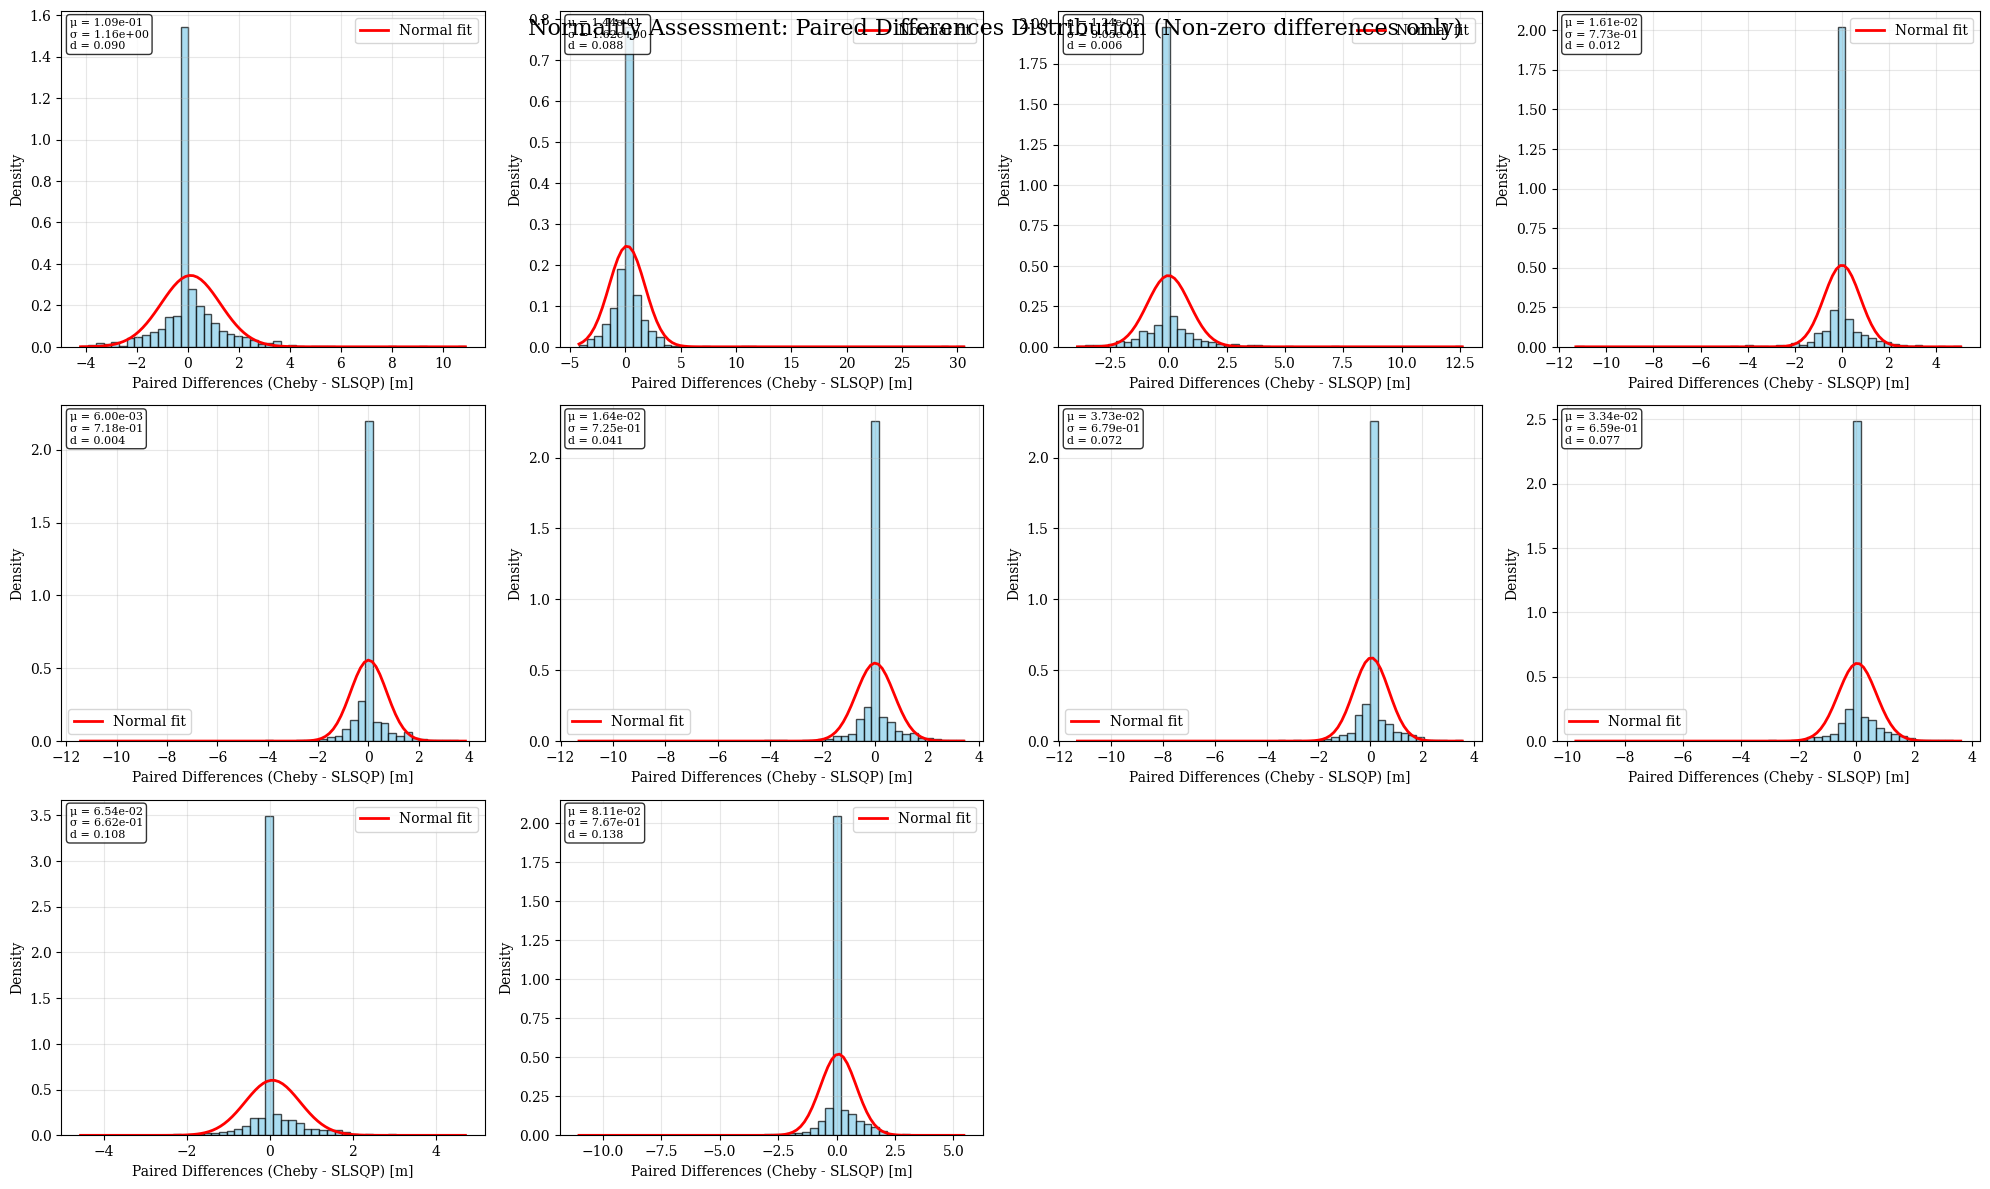


2. Q-Q PLOTS FOR NORMALITY ASSESSMENT


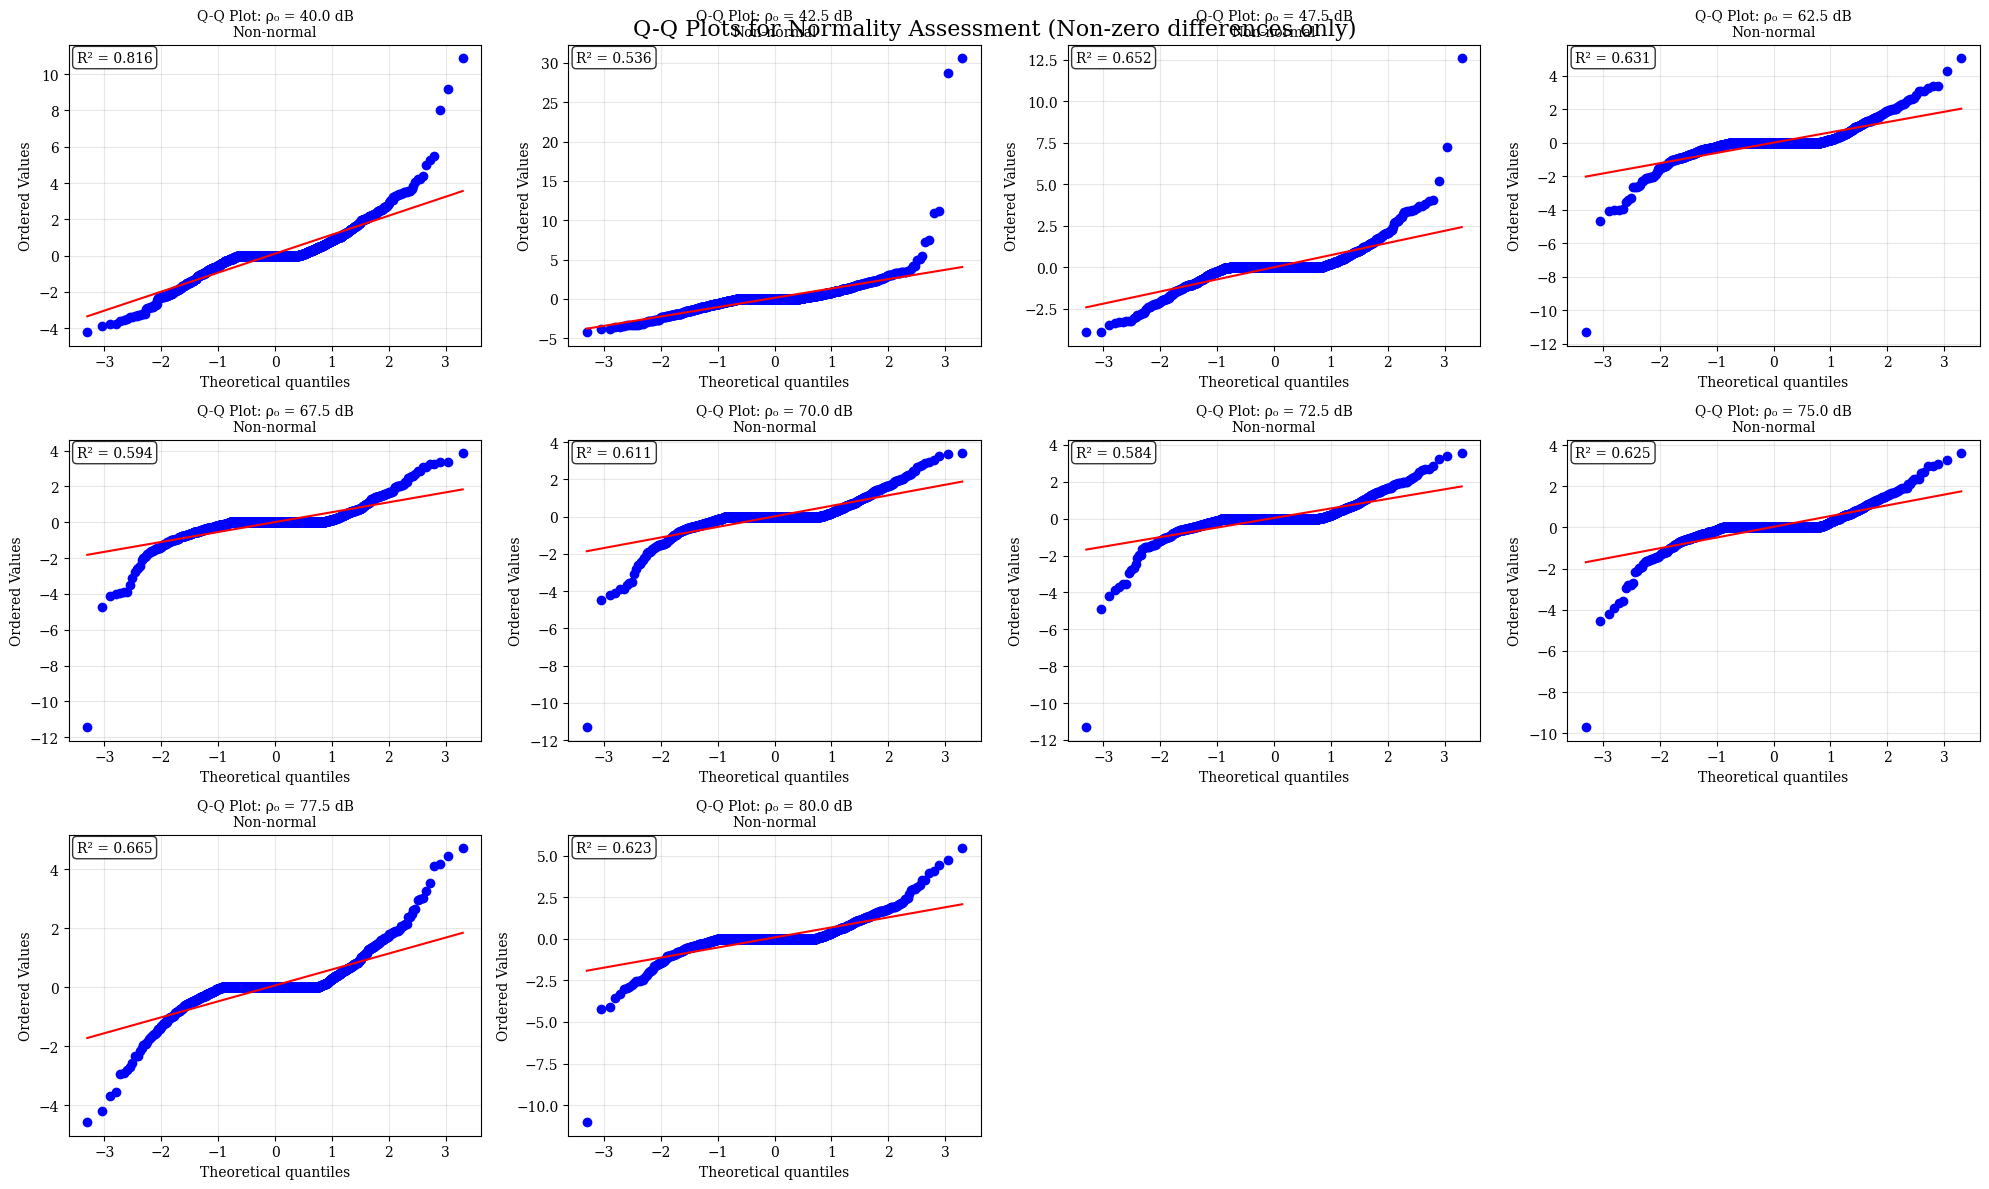


3. ALGORITHM PERFORMANCE COMPARISON


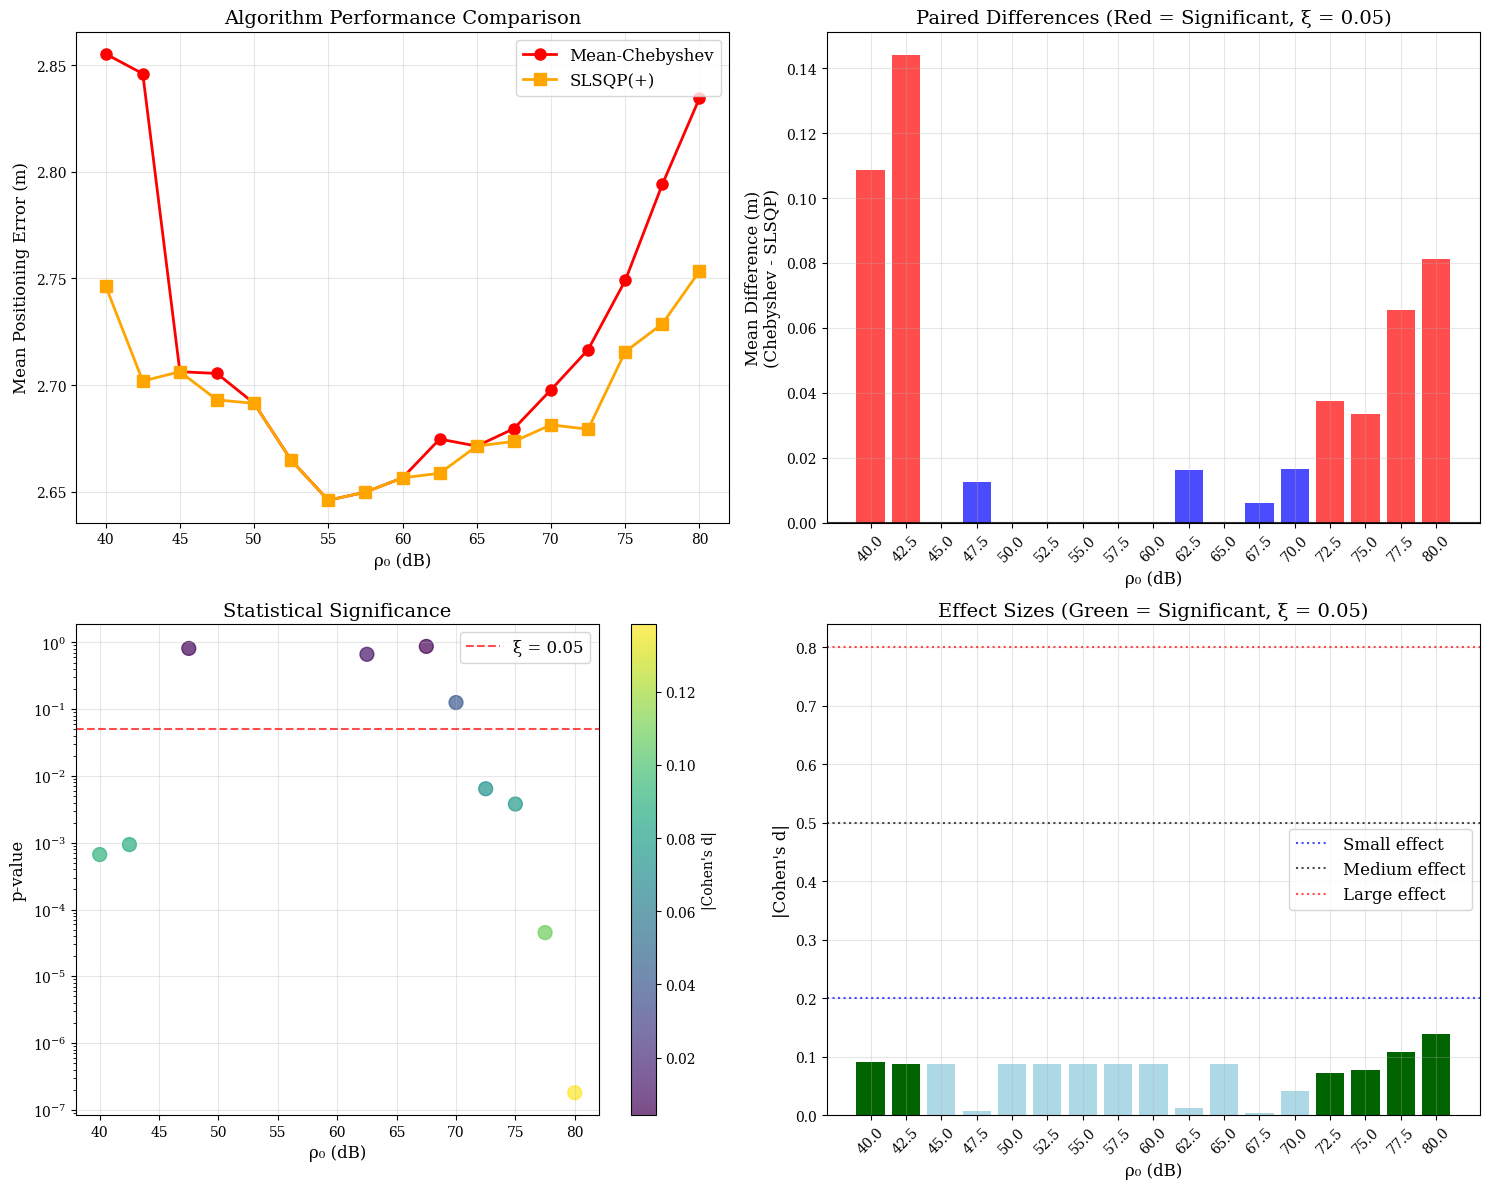

In [ ]:
# Set font to Bookman Old Style
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Bookman Old Style', 'Book Antiqua', 'Times New Roman', 'DejaVu Serif']
plt.rcParams['text.usetex'] = False  # Disable LaTeX rendering
plt.rcParams['mathtext.fontset'] = 'stix'  # Use STIX fonts for math text
print("Using Bookman Old Style font")

project_root = Path().resolve().parent

# COMPREHENSIVE GRAPHICAL ANALYSIS
print("\n" + "="*100)
print("COMPREHENSIVE GRAPHICAL ANALYSIS")
print("="*100)

if comprehensive_analysis_results:

    # 1. NORMALITY ASSESSMENT PLOTS
    print("\n1. NORMALITY ASSESSMENT OF PAIRED DIFFERENCES")
    print("="*60)

    from scipy import stats as scipy_stats

    # Filter out results with zero mean differences
    non_zero_results = [r for r in comprehensive_analysis_results if abs(r['mean_difference']) > 1e-10]
    print(f"Showing plots for {len(non_zero_results)} ρ₀ values with non-zero differences (excluding {len(comprehensive_analysis_results) - len(non_zero_results)} zero-difference cases)")

    if non_zero_results:
        # Calculate grid dimensions for all non-zero results
        n_plots = len(non_zero_results)
        n_cols = min(4, n_plots)  # Maximum 4 columns
        n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_plots == 1:
            axes = [axes]  # Make it iterable
        elif n_rows == 1:
            axes = axes.reshape(1, -1)  # Ensure 2D array
        axes = axes.flatten()

        for i, result in enumerate(non_zero_results):
            rho_0 = result['rho_0']
            paired_differences = result['paired_differences']
            is_normal = result['is_normal']

            ax = axes[i]

            # Histogram with normal overlay
            ax.hist(paired_differences, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')

            # Overlay normal distribution
            mean_diff = np.mean(paired_differences)
            std_diff = np.std(paired_differences, ddof=1)
            x_range = np.linspace(paired_differences.min(), paired_differences.max(), 100)
            normal_overlay = scipy_stats.norm.pdf(x_range, mean_diff, std_diff)
            ax.plot(x_range, normal_overlay, 'r-', linewidth=2, label='Normal fit')

            # Formatting
            # ax.set_title(f'ρ₀ = {rho_0:.1f} dB\n{"Normal" if is_normal else "Non-normal"} (n={len(paired_differences)})', fontsize=10)
            ax.set_xlabel('Paired Differences (Cheby - SLSQP) [m]')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True, alpha=0.3)

            # Add statistics text
            stats_text = f'μ = {mean_diff:.2e}\nσ = {std_diff:.2e}\nd = {result["cohens_d"]:.3f}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                    fontsize=8)

        # Hide unused subplots
        for i in range(n_plots, len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.suptitle('Normality Assessment: Paired Differences Distribution (Non-zero differences only)', fontsize=16, y=0.98)
        plt.show()
    else:
        print("No non-zero differences found for plotting!")

    # 2. Q-Q PLOTS FOR NORMALITY ASSESSMENT
    print("\n2. Q-Q PLOTS FOR NORMALITY ASSESSMENT")
    print("="*50)

    if non_zero_results:
        # Use the same filtered results (non-zero differences)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_plots == 1:
            axes = [axes]  # Make it iterable
        elif n_rows == 1:
            axes = axes.reshape(1, -1)  # Ensure 2D array
        axes = axes.flatten()

        for i, result in enumerate(non_zero_results):
            rho_0 = result['rho_0']
            paired_differences = result['paired_differences']
            is_normal = result['is_normal']

            ax = axes[i]

            # Q-Q plot
            scipy_stats.probplot(paired_differences, dist="norm", plot=ax)
            ax.set_title(f'Q-Q Plot: ρ₀ = {rho_0:.1f} dB\n{"Normal" if is_normal else "Non-normal"}', fontsize=10)
            ax.grid(True, alpha=0.3)

            # Add R² for goodness of fit
            # Calculate R² for the Q-Q plot
            theoretical_quantiles = scipy_stats.probplot(paired_differences, dist="norm")[0][0]
            sample_quantiles = scipy_stats.probplot(paired_differences, dist="norm")[0][1]
            correlation = np.corrcoef(theoretical_quantiles, sample_quantiles)[0, 1]
            r_squared = correlation ** 2

            ax.text(0.02, 0.98, f'R² = {r_squared:.3f}', transform=ax.transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Hide unused subplots
        for i in range(n_plots, len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.suptitle('Q-Q Plots for Normality Assessment (Non-zero differences only)', fontsize=16, y=0.98)
        plt.show()
    else:
        print("No non-zero differences found for Q-Q plots!")

    # 3. ALGORITHM COMPARISON PLOTS
    print("\n3. ALGORITHM PERFORMANCE COMPARISON")
    print("="*50)

    # Extract data for plotting
    rho_values = [r['rho_0'] for r in comprehensive_analysis_results]
    cheby_means = [r['cheby_mean'] for r in comprehensive_analysis_results]
    slsqp_means = [r['slsqp_mean'] for r in comprehensive_analysis_results]
    mean_diffs = [r['mean_difference'] for r in comprehensive_analysis_results]
    p_values = [r['p_value'] for r in comprehensive_analysis_results]
    effect_sizes = [abs(r['cohens_d']) for r in comprehensive_analysis_results]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Algorithm Means Comparison
    ax1.plot(rho_values, cheby_means, 'o-', label='Mean-Chebyshev', linewidth=2, markersize=8, color='red')
    ax1.plot(rho_values, slsqp_means, 's-', label='SLSQP(+)', linewidth=2, markersize=8, color='orange')
    ax1.set_xlabel('ρ₀ (dB)', fontsize=12)
    ax1.set_ylabel('Mean Positioning Error (m)', fontsize=12)
    ax1.set_title('Algorithm Performance Comparison', fontsize=14)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Mean Differences
    colors = ['red' if r['is_significant'] else 'blue' for r in comprehensive_analysis_results]
    ax2.bar(range(len(rho_values)), mean_diffs, color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.8)
    ax2.set_xlabel('ρ₀ (dB)', fontsize=12)
    ax2.set_ylabel('Mean Difference (m)\n(Chebyshev - SLSQP)', fontsize=12)
    ax2.set_title('Paired Differences (Red = Significant, ξ = 0.05)', fontsize=14)
    ax2.set_xticks(range(len(rho_values)))
    ax2.set_xticklabels([f'{rho:.1f}' for rho in rho_values], rotation=45)
    ax2.grid(True, alpha=0.3)

    # Plot 3: P-values
    ax3.scatter(rho_values, p_values, c=effect_sizes, cmap='viridis', s=100, alpha=0.7)
    ax3.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='ξ = 0.05')
    ax3.set_xlabel('ρ₀ (dB)', fontsize=12)
    ax3.set_ylabel('p-value', fontsize=12)
    ax3.set_title('Statistical Significance', fontsize=14)
    ax3.set_yscale('log')
    ax3.legend(fontsize=12)
    ax3.grid(True, alpha=0.3)

    # Add colorbar for effect sizes
    cbar = plt.colorbar(ax3.collections[0], ax=ax3)
    cbar.set_label('|Cohen\'s d|')

    # Plot 4: Effect Sizes
    ax4.bar(range(len(rho_values)), effect_sizes,
            color=['darkgreen' if r['is_significant'] else 'lightblue' for r in comprehensive_analysis_results])
    ax4.set_xlabel('ρ₀ (dB)', fontsize=12)
    ax4.set_ylabel('|Cohen\'s d|', fontsize=12)
    ax4.set_title('Effect Sizes (Green = Significant, ξ = 0.05)', fontsize=14)
    ax4.set_xticks(range(len(rho_values)))
    ax4.set_xticklabels([f'{rho:.1f}' for rho in rho_values], rotation=45)

    # Add effect size interpretation lines
    ax4.axhline(y=0.2, color='blue', linestyle=':', alpha=0.7, label='Small effect')
    ax4.axhline(y=0.5, color='black', linestyle=':', alpha=0.7, label='Medium effect')
    ax4.axhline(y=0.8, color='red', linestyle=':', alpha=0.7, label='Large effect')
    ax4.legend(fontsize=12)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("No results available for graphical analysis!")

In [17]:
# Save figure 3 as .pdf into figures directory
figures_dir = project_root / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(figures_dir / 'algorithm_statistical_comparison.pdf', bbox_inches='tight')

In [ ]:
# DETAILED NORMALITY TEST RESULTS AND CONFIDENCE INTERVALS
print("\n" + "="*100)
print("DETAILED NORMALITY TEST RESULTS")
print("="*100)

if comprehensive_analysis_results:

    # Detailed normality test results table
    print("\nDETAILED NORMALITY TEST RESULTS FOR EACH ρ₀:")
    print("="*120)
    print(f"{'ρ₀':<6} {'Shapiro-W':<12} {'Shapiro p':<12} {'KS stat':<10} {'KS p':<12} {'JB stat':<12} {'JB p':<12} {'AD stat':<10} {'Overall':<10}")
    print("="*120)

    for result in comprehensive_analysis_results:
        rho_0 = result['rho_0']
        norm_results = result['normality_results']
        overall_normal = "Normal" if result['is_normal'] else "Non-normal"

        # Extract individual test results
        shapiro_stat = norm_results.get('shapiro', {}).get('statistic', np.nan)
        shapiro_p = norm_results.get('shapiro', {}).get('p_value', np.nan)
        ks_stat = norm_results.get('ks', {}).get('statistic', np.nan)
        ks_p = norm_results.get('ks', {}).get('p_value', np.nan)
        jb_stat = norm_results.get('jarque_bera', {}).get('statistic', np.nan)
        jb_p = norm_results.get('jarque_bera', {}).get('p_value', np.nan)
        ad_stat = norm_results.get('anderson', {}).get('statistic', np.nan)

        print(f"{rho_0:<6.1f} {shapiro_stat:<12.4f} {shapiro_p:<12.6e} {ks_stat:<10.4f} {ks_p:<12.6e} {jb_stat:<12.4f} {jb_p:<12.6e} {ad_stat:<10.4f} {overall_normal:<10}")

    print("="*120)

    # CONFIDENCE INTERVALS ANALYSIS
    print("\nCONFIDENCE INTERVALS FOR MEAN DIFFERENCES:")
    print("="*80)
    print(f"{'ρ₀':<6} {'Mean Diff':<12} {'95% CI Lower':<12} {'95% CI Upper':<12} {'CI Width':<12} {'Includes 0?':<12}")
    print("="*80)

    for result in comprehensive_analysis_results:
        rho_0 = result['rho_0']
        mean_diff = result['mean_difference']
        std_diff = result['std_difference']
        n = result['n']

        # 95% Confidence interval for mean difference
        t_critical = scipy_stats.t.ppf(0.975, df=n-1)  # Two-tailed, 95% CI
        margin_of_error = t_critical * (std_diff / np.sqrt(n))
        ci_lower = mean_diff - margin_of_error
        ci_upper = mean_diff + margin_of_error
        ci_width = ci_upper - ci_lower
        includes_zero = "Yes" if ci_lower <= 0 <= ci_upper else "No"

        print(f"{rho_0:<6.1f} {mean_diff:<12.6e} {ci_lower:<12.6e} {ci_upper:<12.6e} {ci_width:<12.6e} {includes_zero:<12}")

    print("="*80)

    # STATISTICAL POWER ANALYSIS
    print("\nSTATISTICAL POWER AND SAMPLE SIZE CONSIDERATIONS:")
    print("="*60)

    sample_size = comprehensive_analysis_results[0]['n']  # Should be same for all
    print(f"Sample size per group: n = {sample_size}")
    print(f"Power analysis for large samples (n ≈ {sample_size}):")
    print("• Very high statistical power (>99%) to detect even small effects")
    print("• Cohen's d ≥ 0.1 should be detectable with high power")
    print("• Large samples make statistical tests very sensitive")
    print("• Focus should be on practical significance (effect sizes)")

    # Effect size practical interpretation
    print("\nEFFECT SIZE PRACTICAL INTERPRETATION:")
    print("="*50)

    effect_sizes = [abs(r['cohens_d']) for r in comprehensive_analysis_results]
    mean_effect = np.mean(effect_sizes)

    print(f"Average |Cohen's d|: {mean_effect:.3f}")

    if mean_effect < 0.2:
        practical_meaning = "Very small practical differences"
    elif mean_effect < 0.5:
        practical_meaning = "Small to small-medium practical differences"
    elif mean_effect < 0.8:
        practical_meaning = "Medium practical differences"
    else:
        practical_meaning = "Large practical differences"

    print(f"Practical interpretation: {practical_meaning}")

    # Convert effect sizes to practical units
    print("\nPRACTICAL SIGNIFICANCE IN POSITIONING CONTEXT:")
    print("="*55)

    mean_diffs_mm = [r['mean_difference'] * 1000 for r in comprehensive_analysis_results]  # Convert to mm
    mean_improvement_mm = np.mean([abs(d) for d in mean_diffs_mm])

    print(f"Mean absolute difference: {mean_improvement_mm:.3f} mm")
    print(f"Range of differences: {min(mean_diffs_mm):.3f} to {max(mean_diffs_mm):.3f} mm")

    # Determine which algorithm is generally better
    negative_diffs = sum(1 for d in mean_diffs_mm if d < 0)
    positive_diffs = sum(1 for d in mean_diffs_mm if d > 0)

    if negative_diffs > positive_diffs:
        better_algorithm = "Mean-Chebyshev"
        print(f"Generally better algorithm: {better_algorithm} ({negative_diffs}/{len(mean_diffs_mm)} cases)")
    elif positive_diffs > negative_diffs:
        better_algorithm = "SLSQP(+)"
        print(f"Generally better algorithm: {better_algorithm} ({positive_diffs}/{len(mean_diffs_mm)} cases)")
    else:
        print("No clear winner: algorithms perform similarly")

else:
    print("No results available for detailed analysis!")


DETAILED NORMALITY TEST RESULTS

DETAILED NORMALITY TEST RESULTS FOR EACH ρ₀:
ρ₀     Shapiro-W    Shapiro p    KS stat    KS p         JB stat      JB p         AD stat    Overall   
40.0   0.8182       2.592915e-37 0.2016     4.462039e-51 8167.7155    0.000000e+00 95.4528    Non-normal
42.5   0.5406       2.065257e-51 0.2019     3.265048e-51 1498116.2618 0.000000e+00 131.3678   Non-normal
45.0   1.0000       1.000000e+00 nan        nan          nan          nan          nan        Non-normal
47.5   0.6557       8.929323e-47 0.2915     2.120984e-107 67603.3697   0.000000e+00 184.0003   Non-normal
50.0   1.0000       1.000000e+00 nan        nan          nan          nan          nan        Non-normal
52.5   1.0000       1.000000e+00 nan        nan          nan          nan          nan        Non-normal
55.0   1.0000       1.000000e+00 nan        nan          nan          nan          nan        Non-normal
57.5   1.0000       1.000000e+00 nan        nan          nan          nan       